In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,precision_recall_curve
import statsmodels.formula.api as sm
from xgboost import XGBClassifier
import datetime
from datetime import *

In [5]:
def plot_confusion_matrix(y_true,y_pred,Train,Test):
    if Train=='Yes':
        sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt="d",cbar=False,cmap="YlGnBu")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Training data confusion matrix")
        df_cm = pd.DataFrame(data=confusion_matrix(y_true,y_pred),columns = ["Predicted : 0","Predicted : 1"],index=["Actual : 0","Actual : 1"])
        return df_cm
    else:
        sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt="d",cbar=False,cmap="YlGnBu")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.title("Testing data confusion matrix")
        df_cm = pd.DataFrame(data=confusion_matrix(y_true,y_pred),columns = ["Predicted : 0","Predicted : 1"],index=["Actual : 0","Actual : 1"])
        return df_cm

In [6]:
def roc_auc(y_true,prob_1,Train,Test):
    if Train=='Yes':
        fpr, tpr, thresholds = roc_curve(y_true,prob_1)
        df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
        auc=roc_auc_score(y_true,prob_1)
        plt.plot(fpr,tpr,label="AUC="+str(auc))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title("Training data AUC")
        plt.legend(loc=0)
        plt.show()
    else:
        fpr, tpr, thresholds = roc_curve(y_true,prob_1)
        df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
        auc=roc_auc_score(y_true,prob_1)
        plt.plot(fpr,tpr,label="AUC="+str(auc))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title("Testing data AUC")
        plt.legend(loc=0)
        plt.show()

In [7]:
train = pd.read_csv("C:\\Users\\yashs\\OneDrive\\Desktop\\XGBoost\\Dataset\\Train_nyOWmfK.csv",encoding='ISO-8859–1')

In [8]:
train.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [9]:
train = pd.read_csv("C:\\Users\\yashs\\OneDrive\\Desktop\\XGBoost\\Dataset\\Train_nyOWmfK.csv",encoding='ISO-8859–1')

In [10]:
test = pd.read_csv("C:\\Users\\yashs\\OneDrive\\Desktop\\Dataset\\Test_bCtAN1w.csv")

In [11]:
train.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed'],
      dtype='object')

In [12]:
print(train.shape)
print(test.shape)

(87020, 26)
(37717, 24)


In [13]:
for i in list(train.columns):
    if i not in list(test.columns):
        print(i)

LoggedIn
Disbursed


In [14]:
train["source"]='train'
test["source"]='test'

In [15]:
df = pd.concat([train,test],axis=0,ignore_index=True)

In [16]:
train.shape

(87020, 27)

In [17]:
train["Disbursed"].value_counts()

0    85747
1     1273
Name: Disbursed, dtype: int64

In [18]:
cat_col = list(df.select_dtypes(include=["O"]).columns)
cont_col = list(df.select_dtypes(include=["int","float"]).columns)

In [19]:
def num_unique_values(df):
    data = []
    for i in df.columns:
         data.append(df[i].nunique())
    s=pd.DataFrame({"Name of column":df.columns,"Number of unique values":data})
    return s

In [20]:
df[cat_col].columns

Index(['ID', 'Gender', 'City', 'DOB', 'Lead_Creation_Date', 'Employer_Name',
       'Salary_Account', 'Mobile_Verified', 'Var1', 'Filled_Form',
       'Device_Type', 'Var2', 'Source', 'source'],
      dtype='object')

In [21]:
num_unique_values(df[cat_col])

,Name of column,Number of unique values
0,ID,124737
1,Gender,2
2,City,723
3,DOB,12230
4,Lead_Creation_Date,92
5,Employer_Name,57194
6,Salary_Account,58
7,Mobile_Verified,2
8,Var1,19
9,Filled_Form,2


In [22]:
df.shape

(124737, 27)

In [23]:
df["Disbursed"].shape

(124737,)

In [24]:
test.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'source'],
      dtype='object')

In [25]:
train.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed', 'source'],
      dtype='object')

In [26]:
df.isnull().sum()

ID                           0
Gender                       0
City                      1401
Monthly_Income               0
DOB                          0
Lead_Creation_Date           0
Loan_Amount_Applied        111
Loan_Tenure_Applied        111
Existing_EMI               111
Employer_Name              113
Salary_Account           16801
Mobile_Verified              0
Var5                         0
Var1                         0
Loan_Amount_Submitted    49535
Loan_Tenure_Submitted    49535
Interest_Rate            84901
Processing_Fee           85346
EMI_Loan_Submitted       84901
Filled_Form                  0
Device_Type                  0
Var2                         0
Source                       0
Var4                         0
LoggedIn                 37717
Disbursed                37717
source                       0
dtype: int64

In [27]:
df.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed', 'source'],
      dtype='object')

In [28]:
df["Disbursed"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
124732    NaN
124733    NaN
124734    NaN
124735    NaN
124736    NaN
Name: Disbursed, Length: 124737, dtype: float64

In [29]:
#1 Drop_ID column

In [30]:
data=df.copy()

In [31]:
data.drop("ID",axis=1,inplace=True)

In [32]:
#2. Computation of age

In [33]:
data["DOB"].dtypes

dtype('O')

In [34]:
data["DOB"]=data["DOB"].apply(lambda x:datetime.strptime(x,"%d-%b-%y"))

In [35]:
data["DOB"][0]

Timestamp('1978-05-23 00:00:00')

In [36]:
data["YOB"]=data["DOB"].apply(lambda x:x.year)

In [37]:
data["Age"]=data["YOB"].apply(lambda x:2022-x)

In [38]:
data["Age"]

0         44
1         37
2         41
3         35
4         38
          ..
124732    51
124733    38
124734    53
124735    50
124736    34
Name: Age, Length: 124737, dtype: int64

In [39]:
data.drop("DOB",axis=1,inplace=True)
data.drop("YOB",axis=1,inplace=True)

In [40]:
data.columns

Index(['Gender', 'City', 'Monthly_Income', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed', 'source', 'Age'],
      dtype='object')

In [41]:
data["Disbursed"].value_counts(1)

0.0    0.985371
1.0    0.014629
Name: Disbursed, dtype: float64

In [42]:
data["Lead_Creation_Date"]

0         15-May-15
1         04-May-15
2         19-May-15
3         09-May-15
4         20-May-15
            ...    
124732    31-Jul-15
124733    31-Jul-15
124734    31-Jul-15
124735    31-Jul-15
124736    31-Jul-15
Name: Lead_Creation_Date, Length: 124737, dtype: object

In [43]:
data.drop("City",axis=1,inplace=True)

In [44]:
(data["EMI_Loan_Submitted"].isnull().sum()/data.shape[0])

0.6806400667003375

In [45]:
data["EMI_Loan_Submitted_Missing"]=np.where(data["EMI_Loan_Submitted"].isnull()==True,1,0)

In [46]:
data["EMI_Loan_Submitted_Missing"].value_counts(1)

1    0.68064
0    0.31936
Name: EMI_Loan_Submitted_Missing, dtype: float64

In [47]:
data[["EMI_Loan_Submitted_Missing","EMI_Loan_Submitted"]].head(10)

,EMI_Loan_Submitted_Missing,EMI_Loan_Submitted
0,1,NaN
1,0,6762.90
2,1,NaN
3,1,NaN
4,1,NaN
5,0,6978.92
6,1,NaN
7,1,NaN
8,0,30824.65
9,0,10883.38


In [48]:
data.drop("Employer_Name",axis=1,inplace=True)

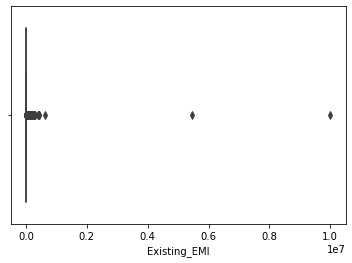

In [49]:
sns.boxplot(x="Existing_EMI",data=data)

In [50]:
data["Existing_EMI"].value_counts(1)

0.0        0.669620
5000.0     0.030539
10000.0    0.020188
3000.0     0.017613
4000.0     0.014283
             ...   
2519.0     0.000008
8663.0     0.000008
230.0      0.000008
46990.0    0.000008
4364.0     0.000008
Name: Existing_EMI, Length: 4704, dtype: float64

In [51]:
data["Existing_EMI"].isnull().sum()

111

In [52]:
data["Existing_EMI"].fillna(value=data["Existing_EMI"].median(),inplace=True)

In [53]:
data.isnull().sum()

Gender                            0
Monthly_Income                    0
Lead_Creation_Date                0
Loan_Amount_Applied             111
Loan_Tenure_Applied             111
Existing_EMI                      0
Salary_Account                16801
Mobile_Verified                   0
Var5                              0
Var1                              0
Loan_Amount_Submitted         49535
Loan_Tenure_Submitted         49535
Interest_Rate                 84901
Processing_Fee                85346
EMI_Loan_Submitted            84901
Filled_Form                       0
Device_Type                       0
Var2                              0
Source                            0
Var4                              0
LoggedIn                      37717
Disbursed                     37717
source                            0
Age                               0
EMI_Loan_Submitted_Missing        0
dtype: int64

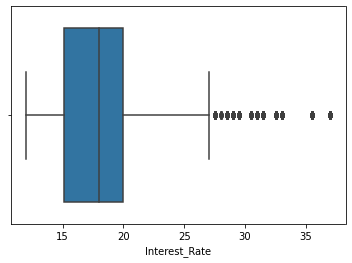

In [54]:
sns.boxplot(data["Interest_Rate"])

In [55]:
data["Interest_Rate"].isnull().sum()/data.shape[0]

0.6806400667003375

In [56]:
data["Interest_Rate_missing"]=np.where(data["Interest_Rate"].isnull()==True,1,0)

In [57]:
data.drop("Interest_Rate",axis=1,inplace=True)

In [58]:
data.drop("Lead_Creation_Date",axis=1,inplace=True)

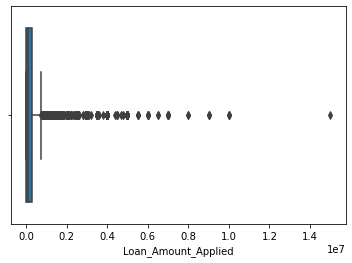

In [59]:
sns.boxplot(data["Loan_Amount_Applied"])

In [60]:
data["Loan_Amount_Applied"].fillna(value=data["Loan_Amount_Applied"].median(),inplace=True)

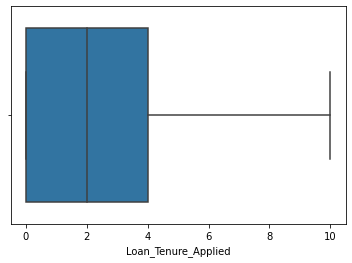

In [61]:
sns.boxplot(data["Loan_Tenure_Applied"])

In [62]:
data["Loan_Tenure_Applied"].describe()

count    124626.000000
mean          2.138197
std           2.015767
min           0.000000
25%           0.000000
50%           2.000000
75%           4.000000
max          10.000000
Name: Loan_Tenure_Applied, dtype: float64

In [63]:
data["Loan_Tenure_Applied"].fillna(value=data["Loan_Tenure_Applied"].median(),inplace=True)

In [64]:
data["Loan_Amount_Submitted"].describe()

count    7.520200e+04
mean     3.949007e+05
std      3.074236e+05
min      5.000000e+04
25%      2.000000e+05
50%      3.000000e+05
75%      5.000000e+05
max      3.000000e+06
Name: Loan_Amount_Submitted, dtype: float64

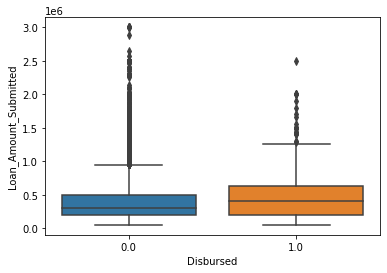

In [65]:
sns.boxplot(x=data["Disbursed"],y=data["Loan_Amount_Submitted"]);

In [66]:
data.columns

Index(['Gender', 'Monthly_Income', 'Loan_Amount_Applied',
       'Loan_Tenure_Applied', 'Existing_EMI', 'Salary_Account',
       'Mobile_Verified', 'Var5', 'Var1', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Processing_Fee', 'EMI_Loan_Submitted',
       'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var4', 'LoggedIn',
       'Disbursed', 'source', 'Age', 'EMI_Loan_Submitted_Missing',
       'Interest_Rate_missing'],
      dtype='object')

In [67]:
data[["Loan_Amount_Submitted","Loan_Tenure_Submitted"]].isnull().sum()/data.shape[0]

Loan_Amount_Submitted    0.397116
Loan_Tenure_Submitted    0.397116
dtype: float64

In [68]:
data["Loan_Amount_Submitted_Missing"]=np.where(data["Loan_Amount_Submitted"].isnull()==True,1,0)

In [69]:
data["Loan_Tenure_Submitted_Missing"]=np.where(data["Loan_Amount_Submitted"].isnull()==True,1,0)

In [70]:
data.drop(["Loan_Amount_Submitted","Loan_Tenure_Submitted"],axis=1,inplace=True)

In [71]:
data.drop("LoggedIn",axis=1,inplace=True)

In [72]:
data.drop("Salary_Account",axis=1,inplace=True)

In [73]:
data["Processing_Fee_missing"]=np.where(data["Processing_Fee"].isnull()==True,1,0)

In [74]:
data["source"].unique()

array(['train', 'test'], dtype=object)

In [75]:
train["Source"].unique()

array(['S122', 'S143', 'S134', 'S133', 'S159', 'S151', 'S137', 'S127',
       'S144', 'S123', 'S156', 'S153', 'S124', 'S161', 'S139', 'S154',
       'S157', 'S138', 'S162', 'S141', 'S158', 'S125', 'S129', 'S136',
       'S130', 'S155', 'S160', 'S150', 'S135', 'S140'], dtype=object)

In [76]:
data['Source'] = data['Source'].apply(lambda x: 'others' if x not in ['S122','S133'] else x)
data['Source'].value_counts()

S122      55249
S133      42900
others    26588
Name: Source, dtype: int64

In [77]:
data.drop(["Processing_Fee","EMI_Loan_Submitted"],axis=1,inplace=True)

## Final data

In [78]:
data.apply(lambda x: sum(x.isnull()))

Gender                               0
Monthly_Income                       0
Loan_Amount_Applied                  0
Loan_Tenure_Applied                  0
Existing_EMI                         0
Mobile_Verified                      0
Var5                                 0
Var1                                 0
Filled_Form                          0
Device_Type                          0
Var2                                 0
Source                               0
Var4                                 0
Disbursed                        37717
source                               0
Age                                  0
EMI_Loan_Submitted_Missing           0
Interest_Rate_missing                0
Loan_Amount_Submitted_Missing        0
Loan_Tenure_Submitted_Missing        0
Processing_Fee_missing               0
dtype: int64

In [79]:
cat_col = data.select_dtypes(include=["O"]).columns

In [80]:
cat_col

Index(['Gender', 'Mobile_Verified', 'Var1', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'source'],
      dtype='object')

In [81]:
for i in cat_col:
    print(data[i].unique())
    print(i)
    print("---")

['Female' 'Male']
Gender
---
['N' 'Y']
Mobile_Verified
---
['HBXX' 'HBXA' 'HAXM' 'HAXB' 'HBXC' 'HBXD' 'HBXH' 'HAXA' 'HBXB' 'HAYT'
 'HCXD' 'HVYS' 'HAVC' 'HCXG' 'HAZD' 'HCYS' 'HCXF' 'HAXC' 'HAXF']
Var1
---
['N' 'Y']
Filled_Form
---
['Web-browser' 'Mobile']
Device_Type
---
['G' 'B' 'C' 'E' 'F' 'D' 'A']
Var2
---
['S122' 'others' 'S133']
Source
---
['train' 'test']
source
---


In [82]:
from sklearn.preprocessing import OrdinalEncoder

In [83]:
oe = OrdinalEncoder(categories=[['Female','Male'],['N','Y'],['N','Y'],['Web-browser','Mobile']])

In [84]:
data[['Gender','Mobile_Verified','Filled_Form',"Device_Type"]]=oe.fit_transform(data[['Gender','Mobile_Verified','Filled_Form',"Device_Type"]])

In [85]:
cat_col = data.select_dtypes(include=['O']).columns

In [86]:
cat_col=list(cat_col)

In [87]:
cat_col.remove("source")

In [88]:
cat_col

['Var1', 'Var2', 'Source']

In [89]:
data1 = pd.get_dummies(data=data,columns=cat_col,drop_first=True)

In [90]:
data=data1.copy()

In [91]:
train = data.loc[data["source"]=='train',:]
test = data.loc[data["source"]=='test',:]

In [92]:
train.drop("source",axis=1,inplace=True)
test.drop(columns=["source","Disbursed"],axis=1,inplace=True)

In [93]:
train.to_csv("Train.csv")
test.to_csv("Test.csv")

### Train test splitting

In [94]:
X=train.drop("Disbursed",axis=1)
Y=train["Disbursed"]

In [95]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=100)

### Modeling starts

In [108]:
import xgboost as xgb

In [103]:
import optuna

In [ ]:
def objective(trial):
    n_estimators=trial.suggest_int("n_estimators",100,250,step=10)
    learning_rate=trial.suggest_float("learning_rate",1e-7,0.3,log=True)
    scale_pos_weight=trial.suggest_int("scale_pos_weight",1,80,step=1)
    max_depth=trial.suggest_int("max_depth",3,12,step=1)
    min_child_weight=trial.suggest_int("min_child_weight",1,15,step=1)
    gamma=trial.suggest_float("gamma",1e-5,0.5,log=True)
    subsample=trial.suggest_float("subsample",0.5,1,log=True)
    colsample_bytree=trial.suggest_float("colsample_bytree",0.5,1,log=True)
    reg_lambda=trial.suggest_int("reg_lambda",0,50,step=1)
    reg_alpha=trial.suggest_int("reg_alpha",0,50,step=1)
    clf = xgb.XGBClassifier(n_estimators=n_estimators,learning_rate=learning_rate,scale_pos_weight=scale_pos_weight,
                            max_depth=max_depth,min_child_weight=min_child_weight,gamma=gamma,
                            subsample=subsample,colsample_bytree=colsample_bytree,reg_lambda=reg_lambda,
                            reg_alpha=reg_alpha)
    skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    scores = cross_val_score(clf,X,Y,scoring='neg_log_loss',cv=skf,n_jobs=-1)
    log_loss = np.mean(-scores)
    return log_loss

In [ ]:
study = optuna.create_study(direction="minimize",study_name="logg-loss-min")

In [ ]:
study.optimize(objective,n_trials=10)

In [96]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [100]:
XGBC = XGBClassifier(eval_metric='auc',learning_rate=1e-5)

In [101]:
skf = StratifiedKFold(n_splits=5)

In [102]:
XGBC.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1e-05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [98]:
def out_pred(X_train,X_test,model):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    return train_pred,test_pred

In [99]:
train_pred,test_pred = out_pred(X_train,X_test,XGBC)

In [100]:
def out_pred_proba(X_train,X_test,model):
    train_pred_proba = model.predict_proba(X_train)
    test_pred_proba = model.predict_proba(X_test)
    return train_pred_proba,test_pred_proba

In [101]:
train_pred_proba,test_pred_proba=out_pred_proba(X_train,X_test,XGBC)

,Predicted : 0,Predicted : 1
Actual : 0,60047,2
Actual : 1,791,74


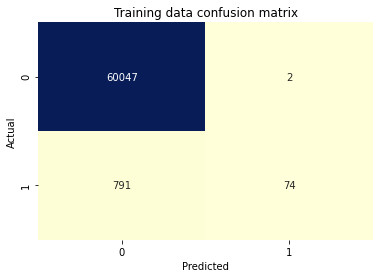

In [102]:
plot_confusion_matrix(Y_train,train_pred,'Yes',None)

In [103]:
print(classification_report(Y_train,train_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     60049
         1.0       0.97      0.09      0.16       865

    accuracy                           0.99     60914
   macro avg       0.98      0.54      0.58     60914
weighted avg       0.99      0.99      0.98     60914



,Predicted : 0,Predicted : 1
Actual : 0,25693,5
Actual : 1,406,2


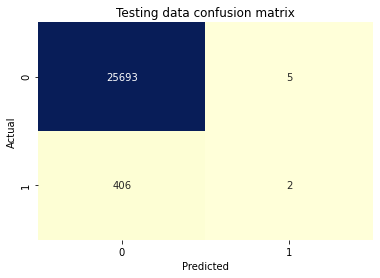

In [104]:
plot_confusion_matrix(Y_test,test_pred,None,'Yes')

In [105]:
print(classification_report(Y_test,test_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     25698
         1.0       0.29      0.00      0.01       408

    accuracy                           0.98     26106
   macro avg       0.64      0.50      0.50     26106
weighted avg       0.97      0.98      0.98     26106



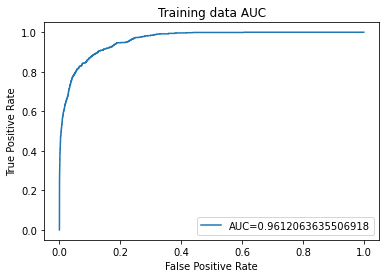

In [106]:
roc_auc(Y_train,train_pred_proba[:,1],'Yes',None)

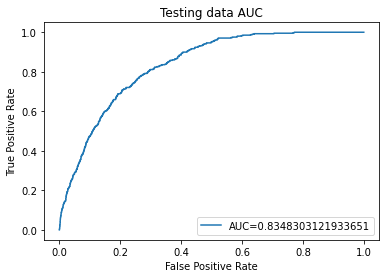

In [107]:
roc_auc(Y_test,test_pred_proba[:,1],None,'Yes')

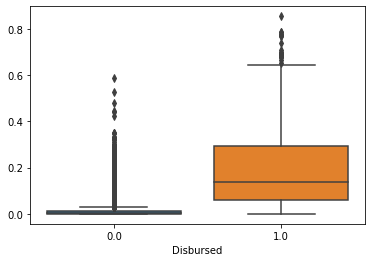

In [108]:
sns.boxplot(x=Y_train,y=train_pred_proba[:,1])

In [109]:
def optimal_threshold_classification_fscore_optimized(y_true,prob_1):
    fpr, tpr, thresholds = roc_curve(y_true,prob_1)
    precision, recall, thresholds = precision_recall_curve(y_true,prob_1)
    fscore = (2 * precision * recall) / (precision + recall)
    # Find the optimal threshold
    index = np.argmax(fscore)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    fscoreOpt = round(fscore[index], ndigits = 4)
    recallOpt = round(recall[index], ndigits = 4)
    precisionOpt = round(precision[index], ndigits = 4)
    print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
    print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

In [110]:
optimal_threshold_classification_fscore_optimized(Y_train,train_pred_proba[:,1])

Best Threshold: 0.16040000319480896 with F-Score: 0.5428
Recall: 0.4694, Precision: 0.6434


In [111]:
def threshold_change(threshold,prob_1):
    class1=[]
    for i in prob_1:
        if i>threshold:
            class1.append(1)
        else:
            class1.append(0)
    return class1

In [112]:
updated_train_pred=threshold_change(0.16040000319480896,train_pred_proba[:,1])

In [113]:
updated_test_pred=threshold_change(0.16040000319480896,test_pred_proba[:,1])

,Predicted : 0,Predicted : 1
Actual : 0,59824,225
Actual : 1,460,405


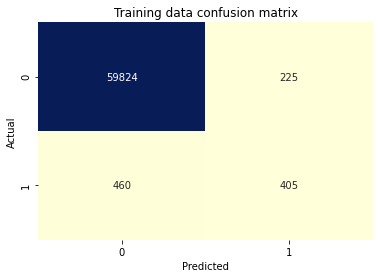

In [114]:
plot_confusion_matrix(Y_train,updated_train_pred,'Yes',None)

In [115]:
print(classification_report(Y_train,updated_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     60049
         1.0       0.64      0.47      0.54       865

    accuracy                           0.99     60914
   macro avg       0.82      0.73      0.77     60914
weighted avg       0.99      0.99      0.99     60914



,Predicted : 0,Predicted : 1
Actual : 0,25531,167
Actual : 1,372,36


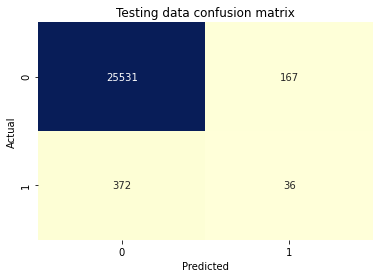

In [116]:
plot_confusion_matrix(Y_test,updated_test_pred,None,'Yes')

In [117]:
print(classification_report(Y_test,updated_test_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25698
         1.0       0.18      0.09      0.12       408

    accuracy                           0.98     26106
   macro avg       0.58      0.54      0.55     26106
weighted avg       0.97      0.98      0.98     26106



### Hyper-parameter tuning

In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
#Step 1.
#setting up the number of estimators and learning rate

In [120]:
XGBC = XGBClassifier(eval_metric='auc')

In [121]:
skf = StratifiedKFold(n_splits=5)

In [122]:
n_estimators = [100,120,140,160,180]
learning_rate = [1e-2,2e-2,3e-2,4e-2,5e-2,0.1,0.15,0.18]

In [123]:
param_grid = {'n_estimators':[100,120,140,160,180],'learning_rate':[1e-2,2e-2,3e-2,4e-2,5e-2,0.1,0.15,0.18]}

In [124]:
gsearch1 = GridSearchCV(estimator=XGBC,param_grid=param_grid,cv=5,scoring='f1_macro')

In [125]:
gsearch1.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1,
                                           0.15, 0.18],
                         'n_estimators': [100, 120, 140, 160, 180]},
             scoring='f1_macro')

In [126]:
df1=pd.DataFrame(gsearch1.cv_results_)

In [127]:
df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.820297,0.136796,0.014929,0.001091,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",0.496404,0.496425,0.496425,0.496425,0.496424,0.496420,8.297543e-06,38
1,3.769660,0.526017,0.027347,0.004671,0.01,120,"{'learning_rate': 0.01, 'n_estimators': 120}",0.496404,0.496425,0.496425,0.496425,0.496424,0.496420,8.297543e-06,38
2,7.793464,0.574258,0.043978,0.005984,0.01,140,"{'learning_rate': 0.01, 'n_estimators': 140}",0.496404,0.496425,0.496425,0.496425,0.496424,0.496420,8.297543e-06,38
3,5.921579,0.125959,0.038898,0.002536,0.01,160,"{'learning_rate': 0.01, 'n_estimators': 160}",0.496425,0.496425,0.496425,0.496425,0.496424,0.496425,1.182395e-07,23
4,6.780398,1.405930,0.037884,0.010847,0.01,180,"{'learning_rate': 0.01, 'n_estimators': 180}",0.496425,0.496425,0.496425,0.496425,0.496424,0.496425,1.182395e-07,23
5,3.091141,0.085384,0.024378,0.000636,0.02,100,"{'learning_rate': 0.02, 'n_estimators': 100}",0.502192,0.496425,0.496425,0.496425,0.496424,0.497578,2.307088e-03,5
6,3.785101,0.097721,0.025724,0.003859,0.02,120,"{'learning_rate': 0.02, 'n_estimators': 120}",0.496425,0.496425,0.496425,0.496425,0.496424,0.496425,1.182395e-07,23
7,4.823673,0.358415,0.031990,0.006466,0.02,140,"{'learning_rate': 0.02, 'n_estimators': 140}",0.496425,0.496425,0.496425,0.496425,0.496424,0.496425,1.182395e-07,23
8,5.129018,0.176380,0.038468,0.011371,0.02,160,"{'learning_rate': 0.02, 'n_estimators': 160}",0.496425,0.496425,0.496425,0.496425,0.496424,0.496425,1.182395e-07,23
9,5.727700,0.084146,0.038594,0.003349,0.02,180,"{'learning_rate': 0.02, 'n_estimators': 180}",0.496425,0.496425,0.496425,0.496425,0.496424,0.496425,1.182395e-07,23


In [128]:
gsearch1.best_params_

{'learning_rate': 0.15, 'n_estimators': 120}

In [129]:
gsearch1.best_score_

0.4986328567608783

In [130]:
#Step #2 : scale_pos_weight

In [131]:
(Y_train.loc[Y_train==0].shape[0])/(Y_train.loc[Y_train==1].shape[0])

69.42080924855492

In [132]:
param_grid1 = {"scale_pos_weight":[1,10,15,20,25,30,50,55,65,70]}

In [133]:
from xgboost import XGBClassifier

In [134]:
XGBC = XGBClassifier(n_estimators=120,learning_rate=0.15,eval_metric='auc')

In [135]:
skf = StratifiedKFold(n_splits=5)

In [136]:
cv1 = skf

In [137]:
gsearch1 = GridSearchCV(estimator=XGBC,param_grid=param_grid1,cv=cv1,scoring='f1_macro')

In [138]:
gsearch1.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'scale_pos_weight': [1, 10, 15, 20, 25, 30, 50, 55, 65,
                                              70]},
             scoring='f1_macro')

In [139]:
gsearch1.best_params_

{'scale_pos_weight': 15}

In [140]:
gsearch1.best_score_

0.5502938790839759

In [141]:
#Step #3 : max_depth and min_child_weight

In [142]:
param_grid2 = {"max_depth":range(3,10,2),"min_child_weight":range(1,6,2)}

In [143]:
XGBC3 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc')

In [144]:
gsearch2 = GridSearchCV(estimator=XGBC3,param_grid=param_grid2,cv=cv1,scoring='f1_macro')

In [145]:
gsearch2.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1_macro')

In [146]:
gsearch2.best_params_

{'max_depth': 5, 'min_child_weight': 1}

In [147]:
gsearch2.best_score_

0.5549125079806715

In [148]:
#Step #4 : max_depth = [4,5,6]
# min_child_weight = [2,4,6,8,10]

In [149]:
param_grid4 = {"max_depth":[4,5,6],"min_child_weight":[2,4,6,8,10]}

In [150]:
XGBC4 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc')

In [151]:
gsearch4 = GridSearchCV(estimator=XGBC4,param_grid=param_grid4,cv=cv1,scoring='f1_macro')

In [152]:
gsearch4.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'max_depth': [4, 5, 6],
                         'min_child_weight': [2, 4, 6, 8, 10]},
             scoring='f1_macro')

In [153]:
gsearch4.best_params_

{'max_depth': 5, 'min_child_weight': 10}

In [154]:
gsearch4.best_score_

0.5547480449264286

In [155]:
#best parameters so far:
#n_estimators=120
#max_depth=5
#min_child_weight=1
#learning_rate=0.15
#scale_pos_weight=15

In [156]:
#Step #5 - Tune gamma

In [157]:
param_grid4 = {"gamma":[i/10 for i in range(0,5)]}

In [158]:
XGBC4 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc',max_depth=5,min_child_weight=1)

In [159]:
gsearch4 = GridSearchCV(estimator=XGBC4,param_grid=param_grid4,cv=cv1,scoring='f1_macro')

In [160]:
gsearch4.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='f1_macro')

In [161]:
gsearch4.best_params_

{'gamma': 0.0}

In [162]:
gsearch4.best_score_

0.5549125079806715

In [163]:
#Step #6 - Tune subsample colsample_bytree

In [164]:
param_grid4 = {"subsample":[i/10 for i in range(6,10)],"colsample_bytree":[i/10 for i in range(6,10)]}

In [165]:
XGBC4 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc',max_depth=5,min_child_weight=1,
                     gamma=0.0)

In [166]:
gsearch4 = GridSearchCV(estimator=XGBC4,param_grid=param_grid4,cv=cv1,scoring='f1_macro')

In [167]:
gsearch4.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=0.0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='f1_macro')

In [168]:
gsearch4.best_params_

{'colsample_bytree': 0.7, 'subsample': 0.8}

In [169]:
gsearch4.best_score_

0.5505334294128102

In [170]:
#Step #7 - Tune subsample colsample_bytree

In [171]:
param_grid4 = {"subsample":[i/100 for i in range(61,70)],"colsample_bytree":[i/100 for i in range(71,80)]}

In [172]:
XGBC4 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc',max_depth=5,min_child_weight=1,
                     gamma=0.0)

In [173]:
gsearch4 = GridSearchCV(estimator=XGBC4,param_grid=param_grid4,cv=cv1,scoring='f1_macro')

In [174]:
gsearch4.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=0.0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=5, min_child_w...
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.71, 0.72, 0.73, 0.74, 0.75,
                                              0.76, 0.77, 0.78, 0.79],
                         'subsample': [0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67,
                                       0.68, 0.69]},
             scoring='f1_macro')

In [175]:
gsearch4.best_params_

{'colsample_bytree': 0.74, 'subsample': 0.65}

In [176]:
gsearch4.best_score_

0.5523975737785246

In [177]:
#Step #8 - Further tuning subsample colsample_bytree

In [178]:
param_grid4 = {"subsample":[i/100 for i in range(71,80)],"colsample_bytree":[i/100 for i in range(81,90)]}

In [179]:
XGBC4 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc',max_depth=5,min_child_weight=1,
                     gamma=0.0)

In [180]:
gsearch4 = GridSearchCV(estimator=XGBC4,param_grid=param_grid4,cv=cv1,scoring='f1_macro')

In [181]:
gsearch4.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=0.0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=5, min_child_w...
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.81, 0.82, 0.83, 0.84, 0.85,
                                              0.86, 0.87, 0.88, 0.89],
                         'subsample': [0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
                                       0.78, 0.79]},
             scoring='f1_macro')

In [182]:
gsearch4.best_params_

{'colsample_bytree': 0.81, 'subsample': 0.79}

In [183]:
gsearch4.best_score_

0.5533031174658275

In [184]:
#Step #9 - Tuning regularization parameters
#reg_lambda : Ridge regression
#reg_alpha : Lasso regression

In [185]:
param_grid4 = {"reg_lambda":[1e-2,1e-3,1e-4,0.1,],"colsample_bytree":[i/100 for i in range(81,90)]}

In [186]:
XGBC4 = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc',max_depth=5,min_child_weight=1,
                     gamma=0.0)

In [187]:
gsearch4 = GridSearchCV(estimator=XGBC4,param_grid=param_grid4,cv=cv1,scoring='f1_macro')

In [188]:
gsearch4.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=0.0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=5, min_child_w...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=120, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.81, 0.82, 0.83, 0.84, 0.85,
                                              0.86, 0.87, 0.88, 0.89],
                         'reg_lambda': [0.01, 0.001, 0.0001, 0.1]},
             scoring='f1_macro')

In [189]:
gsearch4.best_params_

{'colsample_bytree': 0.86, 'reg_lambda': 0.001}

In [190]:
gsearch4.best_score_

0.5552959207043996

#### Final model

In [191]:
XGBC = XGBClassifier(n_estimators=120,learning_rate=0.15,scale_pos_weight=15,eval_metric='auc',max_depth=5,min_child_weight=1,
                     gamma=0.0,colsample_bytree=0.81,subsample=0.79,reg_alpha=0,reg_lambda=0)

In [192]:
XGBC.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.81, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=15, subsample=0.79, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [193]:
train_pred,test_pred=out_pred(X_train,X_test,XGBC)

In [194]:
train_pred_proba,test_pred_proba=out_pred_proba(X_train,X_test,XGBC)

In [195]:
print(classification_report(Y_test,test_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     25698
         1.0       0.12      0.24      0.16       408

    accuracy                           0.96     26106
   macro avg       0.56      0.60      0.57     26106
weighted avg       0.97      0.96      0.97     26106



In [197]:
import xgboost as xgb

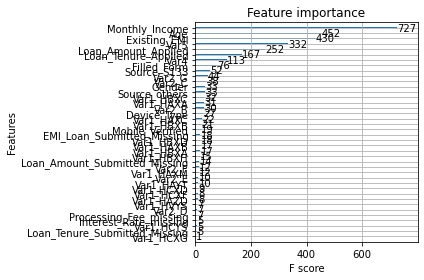

In [203]:
xgb.plot_importance(XGBC)
plt.tight_layout()